# Marker Gene Modulation


Are marker genes regulated by change in burst size or rates of degradation or splicing ?

Check for bursty model. 


In [1]:
# System
import sys

# Math
import numpy as np
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

# scvi
import anndata
import scanpy as sc


# stats
from scipy.stats import ttest_ind

In [4]:
# load in data

# open a file, where you stored the pickled data
# name = 'BVNB_20ct'
# data_dir = '../../data/simulated_data/'


# change name to look at different datasets 
name = 'B08_processed_hv'
data_dir = '../../data/allen/'

results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
data = 'not_simulated'

if data == 'simulated':
    simulated_params = np.load(f'../../data/simulated_data/{name}_params.npy')
else:
    simulated_params = None

results_dict = pickle.load(results_file)
results_file.close()

# read in adata
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata.var_names_make_unique()

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()


if data == 'not_simulated':
    cell_types = adata.obs['Cell Type']
    cell_range = range(len(cell_types.unique()))
    cell_dict = {cell : i for i,cell in enumerate(cell_types.unique())}
    cluster_assignments = np.array([cell_dict[ct] for ct in cell_types])
    print(len(cluster_assignments))
    
else:
    cluster_assignments = np.array([int(ct[2:]) for ct in cell_types])
    

# anndata objects for spliced and unspliced counts
adata_s = adata[:,adata.var['Spliced']==1].copy()    
adata_u = adata[:,adata.var['Spliced']==0].copy()

train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')
cell_types = results_dict.pop('Cell Type')


cluster_labels = adata.obs['cluster_label']

6454


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
# load in marker gene annotations
marker_gene_annotation = pd.read_csv('../../data/Supplementary Table 6')

In [26]:
marker_gene_annotation

,Unnamed: 0,cl1_cluster_label,cl2_cluster_label,cl1_cluster_id,cl2_cluster_id,direction,genes
0,1,Lamp5 Pax6,Lamp5 Egln3_1,1,2,up,Nxph1
1,2,Lamp5 Pax6,Lamp5 Egln3_1,1,2,up,Luzp2
2,3,Lamp5 Pax6,Lamp5 Egln3_1,1,2,up,Scrg1
3,4,Lamp5 Pax6,Lamp5 Egln3_1,1,2,up,Pax6
4,5,Lamp5 Pax6,Lamp5 Egln3_1,1,2,up,Ano3
...,...,...,...,...,...,...,...
4272595,4272596,PVM_3,VLMC_7,116,110,down,Tbc1d16
4272596,4272597,PVM_3,VLMC_7,116,110,down,Taf1c
4272597,4272598,PVM_3,VLMC_7,116,110,down,Tmem159
4272598,4272599,PVM_3,VLMC_7,116,110,down,Dpysl3


In [7]:
# get unique marker genes for clusters
mg_cl1_unique = marker_gene_annotation['cl1_cluster_label'].unique()
mg_cl2_unique = marker_gene_annotation['cl2_cluster_label'].unique()
adata_cl_unique = adata.obs['cluster_label'].unique()
adata_subclass_unique = adata.obs['subclass_label'].unique()

# which clusters/sublcasses are observed in this sample
cl1_adata_overlap = [c for c in mg_cl1_unique if c in adata_cl_unique]
cl2_adata_overlap = [c for c in mg_cl2_unique if c in adata_cl_unique]

In [8]:
#visualize expression of marker genes? 
mg_both_ = [c for c in cl1_adata_overlap if c in cl2_adata_overlap]
print(len(cl1_adata_overlap) - len(mg_both_))
# just one cluster not present in both cl1 and cl2-- will use cl2_adata_overlap

1


In [9]:
# what genes are observed in adata
adata_genes = adata.var['gene_name'].to_list()

In [10]:
# store dictionary of marker genes for each subclass and the direction (up or down regulated)
marker_gene_dict = {cl : {} for cl in cl2_adata_overlap}

for cl in cl2_adata_overlap:
    
    genes = marker_gene_annotation[marker_gene_annotation['cl2_cluster_label'] == cl]['genes'].tolist()
    direction = marker_gene_annotation[marker_gene_annotation['cl2_cluster_label'] == cl]['direction'].tolist()
    mg = [g for g in genes if g in adata_genes]
    mg_direction = [d for i,d in enumerate(direction) if genes[i] in adata_genes]
    marker_gene_dict[cl]['gene'] = mg
    marker_gene_dict[cl]['direction'] = mg_direction


In [16]:
# save marker gene dictionary
with open('../../results/B08_marker_genes_dict.pickle', 'wb') as handle:
    pickle.dump(marker_gene_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
gene = 'Cux2'
direction = 'up'

idx = 1
gene  = marker_gene_dict['Lamp5 Lhx6']['gene'][idx]

#gene = 'Lhx9'

observed_clusters = []
all_clusters = marker_gene_annotation[((marker_gene_annotation['genes'] == gene) & (marker_gene_annotation['direction'] == direction))]['cl2_cluster_label'].unique()

observed_clusters = [c for c in all_clusters if c in adata_cl_unique]

['Lamp5 Lhx6',
 'Sst Chodl',
 'Sst Myh8_1',
 'Sst Myh8_2',
 'Sst Pvalb Etv1',
 'Sst Crhr2_1',
 'Sst Crhr2_2',
 'Sst Calb2',
 'Sst C1ql3_1',
 'Sst C1ql3_2',
 'Pvalb Reln',
 'L6 IT Car3',
 'L5 ET_1',
 'L5 ET_3',
 'L6 CT Gpr139',
 'OPC Pdgfra',
 'Oligo Enpp6_2',
 'Oligo Opalin_1',
 'Oligo Opalin_2',
 'SMC',
 'Lamp5 Pdlim5_1',
 'Lamp5 Pdlim5_2',
 'L5 ET_2',
 'Vip Gpc3',
 'Vip Mybpc1_1']

Text(0.5, 1.0, 'Gene: Shisa9')

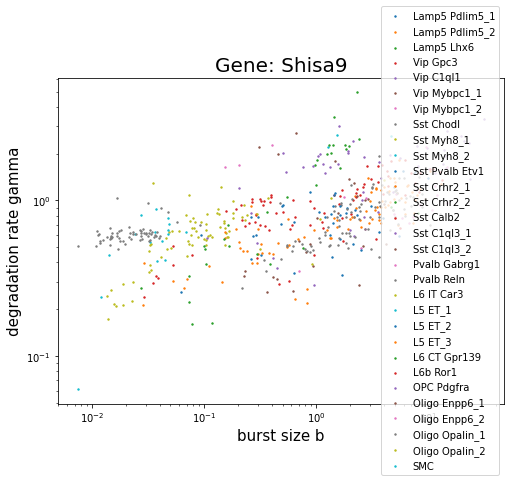

In [21]:
# plot marker gene parameters 
model = 'bursty'
setup = 'Bursty-10-NAS_SHAPE'

cluster_label = 'idk'

#gene = 'Clic4'

index = adata_genes.index(gene)
plt.figure(figsize = (8,6))

for i,cl in enumerate(cl2_adata_overlap):
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    mu1 = results_dict[setup]['params']['mean'][cluster_labels==cl,index]
    mu2 =  results_dict[setup]['params']['mean'][cluster_labels==cl,index+N]
    theta = results_dict[setup]['params']['dispersions'][cluster_labels==cl,index]

    if model == 'bursty':
        b,beta,gamma = get_bursty_params(mu1,mu2,theta)
    elif model == 'constitutive':
        beta,gamma = get_constitutive_params(mu1,mu2)
    elif model == 'BVNB':
        alpha,beta,gamma = get_BVNB_params(mu1,mu2,theta)

    plt.scatter(b,gamma,s=2,label=f'{cl}')
    plt.ylabel('degradation rate gamma',fontsize = 15)
    plt.xlabel('burst size b', fontsize = 15)
    plt.xscale('log')
    plt.yscale('log')
plt.legend(loc='center right',bbox_to_anchor=(1.0, 0.5))
plt.title(f'Gene: {gene}',fontsize = 20)

In [22]:
def get_bursty_params(mu1,mu2,theta):
    ''' Returns b, beta, gamma of bursty distribution given mu1, mu2 and theta.
    Returns whatever size was input. 
    '''
    
    b = mu1/theta
    beta = 1/theta
    gamma = mu1/(mu2*theta)
    
    
    return(b,beta,gamma)

def get_BVNB_params(mu1,mu2,theta):
    ''' Returns splicing rate beta, degradation rate gamma, and alpha (mean of transcription rate distribution) 
    given BVNB extrinsic noise model.
    '''
    alpha = theta
    beta = theta/mu1
    gamma = theta/mu2
    
    
    return(alpha,beta,gamma)

def get_constitutive_params(mu1,mu2):
    ''' Returns rate of splicing rate beta and rate of degradation gamma given constitutive model.
    '''
    beta = 1/mu1
    gamma = 1/mu2
    
    return(beta,gamma)

------


# Differential parameter expression

Calculate the t-value and p-value using less-than, greater-than, and two-sided hypotheses for burst size and degradation rate. Calculates results between subclass and the rest of the observed data points. 

In [23]:
from scipy.stats import ttest_ind

In [24]:
len(adata)

6454

In [25]:
def perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup='Bursty-10-NAS_SHAPE',alternative = ['two-sided','less','greater']):
    ''' Perform three ttests on genes in adata using parameters in results dict. 
    '''
    # define dictionaries to hold t and p values
    b_dict = {}
    beta_dict = {}
    gamma_dict = {}
    alpha_dict = {}
    
    b_dict['genes'] = genes
    beta_dict['genes'] = genes
    gamma_dict['genes'] = genes
    alpha_dict['genes'] = genes
    
    
    # define cluster labels
    cluster_labels = np.array(adata.obs[cluster_label].tolist())
    unique_clusters = np.unique(cluster_labels)
    adata_genes = adata.var['gene_name'].tolist()
    
    N = int(len(results_dict[setup]['params']['mean'][0,:])/2)
    
    # arrays to hold parameters
    b = np.ones((len(adata),len(genes)))
    beta = np.ones((len(adata),len(genes)))
    gamma = np.ones((len(adata),len(genes)))
    alpha = np.ones((len(adata),len(genes)))
    
    # loop through genes and calculate parameters
    for i,g in enumerate(genes):
        index = adata_genes.index(g)
        mu1 = results_dict[setup]['params']['mean'][:,index]
        mu2 =  results_dict[setup]['params']['mean'][:,index+N]
        theta = results_dict[setup]['params']['dispersions'][:,index]
    
        if 'Bursty' in setup:
            b_,beta_,gamma_ = get_bursty_params(mu1,mu2,theta)
            b[:,i] = b_
            beta[:,i] = beta_
            gamma[:,i] = gamma_
        elif 'Poisson' in setup:
            beta_,gamma_ = get_constitutive_params(mu1,mu2)
            beta[:,i] = beta_
            gamma[:,i] = gamma_
        elif 'NBcorr' in setup:
            alpha_,beta_,gamma_ = get_BVNB_params(mu1,mu2,theta)
            alpha[:,i] = alpha_
            beta[:,i] = beta_
            gamma[:,i] = gamma_
            
    for cl in unique_clusters:
        # subset parameters
        b_cl = b[cluster_labels == cl,:]
        beta_c1 = beta[cluster_labels == cl,:]
        gamma_c1 = gamma[cluster_labels == cl,:]
        alpha_c1 = alpha[cluster_labels == cl,:]
        
        b_rest = b[cluster_labels != cl,:]
        beta_rest = beta[cluster_labels != cl,:]
        gamma_rest = gamma[cluster_labels != cl,:]
        alpha_rest = alpha[cluster_labels != cl,:]
        
        # statistics for each parameters
        for alt in alternative:
            statistics_b, pvalues_b = ttest_ind(b_cl, b_rest, axis=0, equal_var= False, 
                              alternative=alt)
            statistics_beta, pvalues_beta = ttest_ind(b_cl, b_rest, axis=0, equal_var= False, 
                              alternative=alt)
            statistics_gamma, pvalues_gamma = ttest_ind(b_cl, b_rest, axis=0, equal_var= False, 
                              alternative=alt)
            statistics_alpha, pvalues_alpha = ttest_ind(b_cl, b_rest, axis=0, equal_var= False, 
                              alternative=alt)
        
            b_dict[f'{cl} t-value, {alt}'] = statistics_b
            beta_dict[f'{cl} t-value, {alt}'] = statistics_beta
            gamma_dict[f'{cl} t-value, {alt}'] = statistics_gamma
            alpha_dict[f'{cl} t-value, {alt}'] = statistics_alpha
            
            b_dict[f'{cl} p-value, {alt}'] = pvalues_b
            beta_dict[f'{cl} p-value, {alt}'] = pvalues_beta
            gamma_dict[f'{cl} p-value, {alt}'] = pvalues_gamma
            alpha_dict[f'{cl} p-value, {alt}'] = pvalues_alpha

    return(b_dict,beta_dict,gamma_dict,alpha_dict)

In [27]:
#two sided test
genes = adata.var['gene_name'].tolist()
b_dict,beta_dict,gamma_dict,alpha_dict = perform_ttest(adata,genes,results_dict,cluster_label='subclass_label',
                   setup='Bursty-10-NAS_SHAPE',alternative = ['two-sided','less','greater'])

<ipython-input-25-9621b37b21cb>:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistics_b, pvalues_b = ttest_ind(b_cl, b_rest, axis=0, equal_var= False,
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
<ipython-input-25-9621b37b21cb>:68: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistics_beta, pvalues_beta = ttest_ind(b_cl, b_rest, axis=0, equal_var= False,
<ipython-input-25-9621b37b21cb>:70: 

In [28]:
b_df = pd.DataFrame(b_dict)
gamma_df = pd.DataFrame(gamma_dict)

### Change in burst size or degradation rate?


In [ ]:
# marker genes that are upregulated in cell-type: increased burst size or decreased gamma or both? 
direction = 'up'

for i,cl in enumerate(cluster_labels):
    
    # select marker genes that are upregulated
    genes = marker_gene_dict[cl]['genes'][marker_gene_dict[cl]['direction'] == direction]
    
    # increased burst size ? 
    subset_df = b_df[b_df['genes'] in genes]
    
    len(b_df[f'{cl} p-value, greater' < 0.05])
    
    